# Generating surrogate distributions

Authors: Isabelle De Backer, 2020; and Joseph Lizier, 2023-; based on the original Matlab tutorials.

In this activity we will generate surrogate distributions to assess the statistical significance of estimates from several different estimator types, and examine their properties.   

1. Start by opening the MI AutoAnalyser. Select a Gaussian estimator, data file `2CoupledRandomCols-1.txt` and click the checkbox next to `Add stat signif.?`. Click `Generate Code and Compute.`

2. Open the Python code tab, read the code from the comment `# 6. Compute the (statistical significance ...` onwards to see how the empirical surrogate distribution is dealt with, and see the results printed in the Status area.

3. Copy the code in the Python code tab into the two code cells below -- the first cell for code up until after the JVM is started, and the other cell for the remainder.

In [1]:
# Paste the import lines and the lines to start the JVM in this code cell:

from jpype import *
import numpy
import sys
# Our python data file readers are a bit of a hack, python users will do better on this:
sys.path.append("/home/joseph/JIDT/infodynamics-dist-1.6/demos/python")
import readFloatsFile

if (not isJVMStarted()):
    # Add JIDT jar library to the path
    jarLocation = "/home/joseph/JIDT/infodynamics-dist-1.6/infodynamics.jar"
    # Start the JVM (add the "-Xmx" option with say 1024M if you get crashes due to not enough memory space)
    startJVM(getDefaultJVMPath(), "-ea", "-Djava.class.path=" + jarLocation)

In [2]:
# Paste the remaining code making calculations etc in this code cell:

# 0. Load/prepare the data:
N = 100; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0; # We'll change this later
destination = numpy.random.normal(size=N); # assign random normal data to destination
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)

print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))


MI_Gaussian(col_0 -> col_1) = 0.0079 nats (null: 0.0052 +/- 0.0071 std dev.; p(surrogate > measured)=0.23100 from 1000 surrogates)


4. Replace the loaded data in the `source` and `destination` variables with the following lines:
```python
N = 100; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0; # We'll change this later
destination = numpy.random.normal(size=N); # assign random normal data to destination
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())
```
Notice that we specifically create 1D arrays by calling `numpy.random.normal(size=N)` -- in contrast, calling `numpy.random.normal(size=(N,1))` creates a 2D array with 1 column. We can use 2D arrays with JIDT (see [full details](https://github.com/jlizier/jidt/wiki/UseInPython) if you're intertested), but since we are computing on univariates, go with the 1D array.

5. Replace the number of surrogates generated in the `measDist = calc.computeSignificance(100)` line from 100 to `S`, to use the above variable. Do the same changing the 100 to `S` in the final `print` statement.

6. Run the code cell above now to make sure you haven't broken it.

7. You can access an array of the surrogate measurements in the `distribution` member of the object `measDist`. You can generate data for a histogram of the surrogate distribution by calling `numpy.histogram()` as below (note the conversion from a java array back to a python numpy array), then using the `matplotlib` to plot it as we have done previously. Run the code in the cell below to do this:

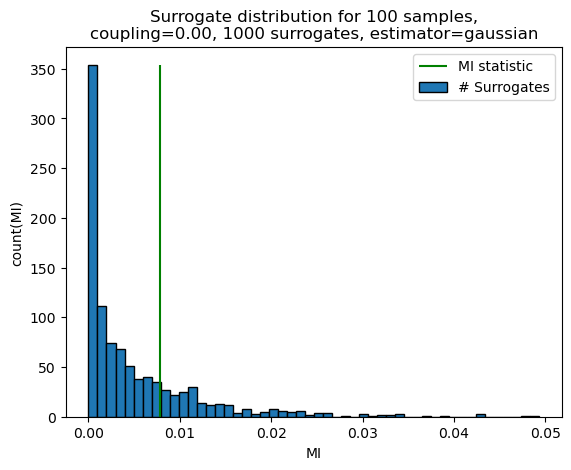

In [3]:
surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

import matplotlib.pyplot as plt
# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');

8. Now let's add a marker to the plot to show where our measured value of MI sits with respect to the surrogate distribution. We'll need some additional data from the histogram for this plot also, so add the following code at the end of the cell above (after the histogram plot):
```python
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
```
And then re-run the cell.

9. And add the following lines to put a nice title and axes on the plot: (This is good practice for your assignments!)
```python
# Now add a nice title and axes to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');
```
And re-run the cell.

A sample plot is in the solutions notebook. (Note the markers of the measured MI in particular, as well as the surrogate distribution to a smaller extent, are stochastic -- so you should not expect your results to match exactly!)

10. Note the scale of the x axis of the surrogate distribution -- now we will change the number of samples `N` to be 10 times larger.
To compare the distributions for this and the following questions, you can either:
    1. save the existing plot to compare to later and then change `N` in the code above and re-run, or
    2. create new cells below to paste the new calculation and plot code to generate new figures. (the solution code does this to keep all of the figures for you)

Whichever you choose, implement this. How do you expect the surrogate distribution to change when it is based on more samples, and why? Run the code and notice how the surrogate distribution changes. Did this match your expectation?

MI_Gaussian(col_0 -> col_1) = 0.0005 nats (null: 0.0005 +/- 0.0007 std dev.; p(surrogate > measured)=0.32500 from 1000 surrogates)


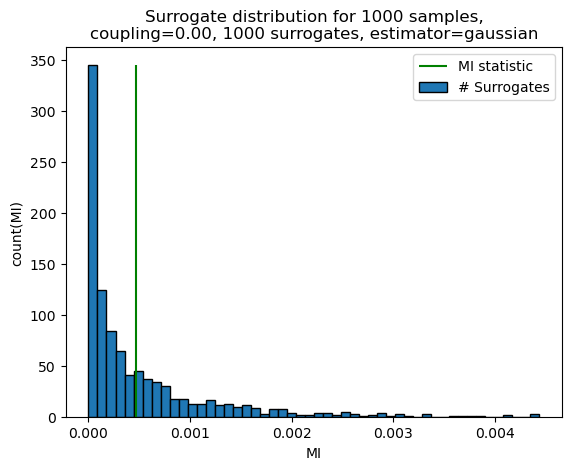

In [4]:
# 0. Load/prepare the data:
N = 1000; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0; # We'll change this later
destination = numpy.random.normal(size=N); # assign random normal data to destination
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)

print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))

surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');

11. Our work so far has dealt with measuring an MI between independent source and destination. Let's introduce a dependence -- this will not change the surrogate distribution, but may change the statistical significance of the measurement. Change the code where the destination variable is assigned (make sure to leave the final JArray conversion after this though):
```python
coupling = 0.01
destination = coupling * source + (1 - coupling) * numpy.random.normal(size=N) # couple the destination to the source
```
12. Do you expect to see a statistically significant MI here because of the coupling? Run the code and find out. Remember that we are sampling, so run the code a few times to get a feeling for the range of results. Reflect on why might you see this outcome regarding the statistical significance?

MI_Gaussian(col_0 -> col_1) = 0.0015 nats (null: 0.0005 +/- 0.0007 std dev.; p(surrogate > measured)=0.08100 from 1000 surrogates)


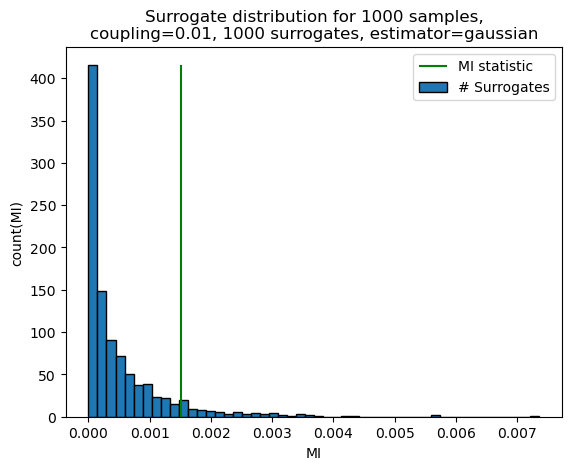

In [5]:
# 0. Load/prepare the data:
N = 1000; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0.01
destination = coupling * source + (1 - coupling) * numpy.random.normal(size=N) # couple the destination to the source
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)

print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))

surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');

13. Let's turn up the `coupling` variable to 0.05 make the effect stronger and see if we can detect the dependence. Does that help or is it still too small to detect, given the number of samples that we have? Try turning the `coupling` variable up higher still if required and observe the difference this makes.

MI_Gaussian(col_0 -> col_1) = 0.0032 nats (null: 0.0005 +/- 0.0007 std dev.; p(surrogate > measured)=0.01200 from 1000 surrogates)


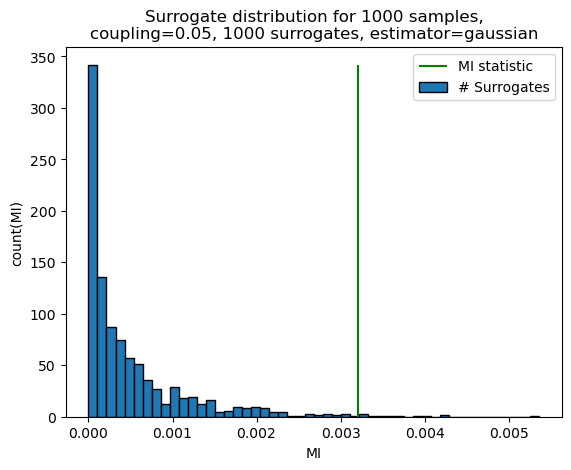

In [6]:
# 0. Load/prepare the data:
N = 1000; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0.05
destination = coupling * source + (1 - coupling) * numpy.random.normal(size=N) # couple the destination to the source
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)

print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))

surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');

Returning the `coupling` variable to 0.05, try using more samples (set `N = 10000;`) -- does this make it easier to discern the dependence effect from background noise? Why?<br/>
What factors have you now observed to help or hinder us to detect dependence between variables from empirical data?

MI_Gaussian(col_0 -> col_1) = 0.0018 nats (null: 0.0000 +/- 0.0001 std dev.; p(surrogate > measured)=0.00000 from 1000 surrogates)


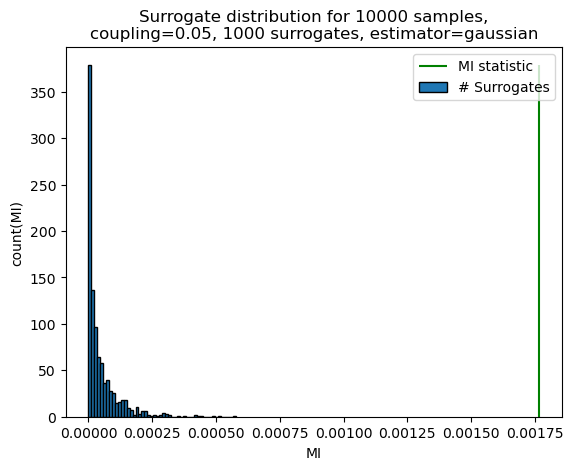

In [7]:
# 0. Load/prepare the data:
N = 10000; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0.05
destination = coupling * source + (1 - coupling) * numpy.random.normal(size=N) # couple the destination to the source
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.gaussian").MutualInfoCalculatorMultiVariateGaussian
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)

print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))

surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');

14. Switch back to `N=1000;` samples and change the calculator type to `KSG (algorithm 1)`. You might want to generate new code to see how to construct this estimator, and then paste the _constructor_ line over the existing code (use the cell below). See how this changes the surrogate distribution:
    1. Compare the means of the surrogate distributions (notice where the KSG surrogate distribution is centred), and relate this to the KSG estimator having bias correction. (The negative values are not incorrect, they simply reflect a value smaller than the expected bias. You can turn on bias correction in the Gaussian estimator to move it's mean to (or towards) zero).
    2. Compare the standard deviations of the surrogate distributions. What factors might contribute to their difference?

MI_Gaussian(col_0 -> col_1) = -0.0268 nats (null: -0.0005 +/- 0.0193 std dev.; p(surrogate > measured)=0.91500 from 1000 surrogates)


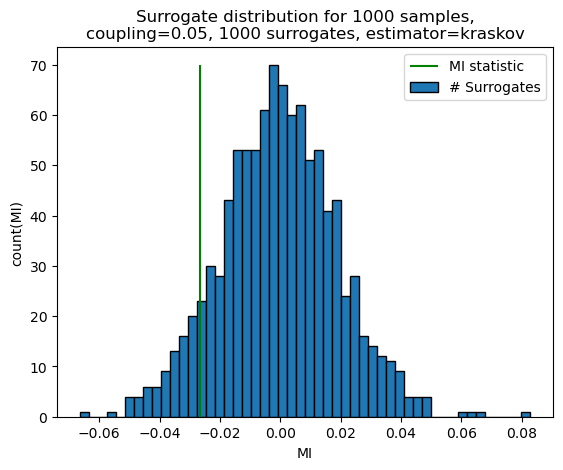

In [8]:
# 0. Load/prepare the data:
N = 1000; # Number of samples to use
S = 1000; # Number of surrogates to generate
source = numpy.random.normal(size=N); # assign random normal data to source
coupling = 0.05
destination = coupling * source + (1 - coupling) * numpy.random.normal(size=N) # couple the destination to the source
# Lastly convert to Java arrays:
source = JArray(JDouble, 1)(source.tolist())
destination = JArray(JDouble, 1)(destination.tolist())

# 1. Construct the calculator:
calcClass = JPackage("infodynamics.measures.continuous.kraskov").MutualInfoCalculatorMultiVariateKraskov1
calc = calcClass()
# 2. Set any properties to non-default values:
# No properties were set to non-default values
# 3. Initialise the calculator for (re-)use:
calc.initialise()
# 4. Supply the sample data:
calc.setObservations(source, destination)
# 5. Compute the estimate:
result = calc.computeAverageLocalOfObservations()
# 6. Compute the (statistical significance via) null distribution empirically (e.g. with 100 permutations):
measDist = calc.computeSignificance(S)

print("MI_Gaussian(col_0 -> col_1) = %.4f nats (null: %.4f +/- %.4f std dev.; p(surrogate > measured)=%.5f from %d surrogates)" %\
    (result, measDist.getMeanOfDistribution(), measDist.getStdOfDistribution(), measDist.pValue, S))

surrogates_hist, hist_edges = numpy.histogram(numpy.array(measDist.distribution), bins=50)

# hist_edges has the lower and upper edge of each bin, so has length 51. Just pass the first 50 items as the x coordinates,
#  and tell plt.bar to align the bars to the left edge. The bar width is the difference between the edges.
plt.bar(hist_edges[:-1], surrogates_hist, width=numpy.diff(hist_edges), align='edge', ec='black', label='# Surrogates');
plt.vlines(x=result, ymin=0, ymax=numpy.max(surrogates_hist), colors='green', label='MI statistic');  # Mark in our measured MI
plt.legend()
# Now add a nice title to the plot
calcName = calcClass.__name__;
calcName = calcName[calcName.index('continuous.') + len('continuous.'):calcName.index('.MutualInfo')]
plt.title('Surrogate distribution for %d samples,\ncoupling=%.2f, %d surrogates, estimator=%s' % (N, coupling, S, calcName));
plt.xlabel('MI')
plt.ylabel('count(MI)');

15. Finally, did the calculation with the KSG estimator find a statistically significant relationship here (for `N=1000` and `coupling=0.05`)? Compare this to the earlier result with the Gaussian estimator, and explain what you observe in terms of the properties of the estimators and how they are suited to the underlying relationship here. Find out how large does the coupling needs to be for 1000 samples in order to observe a statistically significant relationship here? (You can also try to increase the number of samples, but remember the KSG estimator runtime scales as $N \log N$ -- it will need around a minute to calculate for 10000 samples here)